In [1]:
import pandas as pd
import networkx as nx

from preprocess import load_movielens_data, create_bipartite_graph

datapath = "../data/ml-1m"

rating, movies, users = load_movielens_data(datapath)

user_movie_graph = create_bipartite_graph(rating)

Graph created with 9746 nodes and 1000209 edges.


In [2]:
import pandas as pd
import networkx as nx
import numpy as np
from collections import defaultdict
import random

from random_walk_p3 import rank_movies_with_penalty, perform_random_walks
from evaluation import calculate_top_k_accuracy, calculate_correctly_placed_pairs

def evaluate_recommender(graph, walk_length=3, penalty_type="a", k=10):
    """
    Evaluate the recommender system using random walks and penalties.

    Parameters:
    - graph: Bipartite graph.
    - walk_length: Length of each random walk.
    - penalty_type: Type of penalty for unvisited movies.
    - k: Number of top recommendations to consider.

    Returns:
    - avg_top_k_accuracy: Average Top-K accuracy across users.
    - avg_pair_accuracy: Average pairwise accuracy across users.
    """
    users = [node for node, data in graph.nodes(data=True) if data.get("bipartite") == 0]
    avg_top_k_accuracy = 0
    avg_pair_accuracy = 0
    num_users = 0
    results = []

    cnt = 0
    
    for user in users:
        if cnt == 20:
            break
        cnt += 1
        # Get movies watched by user
        watched_movies = set(neighbor for neighbor in graph.neighbors(user) if graph.nodes[neighbor].get("bipartite") == 1)

        if len(watched_movies) > 10:
            num_users += 1

            # Split movies into training and hidden sets
            training_movies = set(random.sample(sorted(watched_movies), 10))
            hidden_movies = watched_movies - training_movies

            # Create temporary graph with training movies only
            temp_graph = graph.copy()
            for movie in hidden_movies:
                temp_graph.remove_edge(user, movie)

            # Perform random walks and rank movies
            movie_visits = perform_random_walks(temp_graph, start_node=user, walk_length=walk_length, num_walks=25)
            recommendations = rank_movies_with_penalty(temp_graph, movie_visits, walk_length=walk_length, penalty_type=penalty_type,total_walks=25)
            
            # Calculate accuracy metrics
            top_k_accuracy = calculate_top_k_accuracy(recommendations, hidden_movies, k)
            pair_accuracy = calculate_correctly_placed_pairs(recommendations, {movie: idx for idx, movie in enumerate(hidden_movies)})

            print(user, top_k_accuracy, pair_accuracy, sep='\n')
            
            avg_top_k_accuracy += top_k_accuracy
            avg_pair_accuracy += pair_accuracy
            results.append({
                "user": user,
                "top_k_accuracy": top_k_accuracy,
                "pair_accuracy": pair_accuracy
            })
    # Average the accuracies
    avg_top_k_accuracy /= num_users
    avg_pair_accuracy /= num_users

    return avg_top_k_accuracy, avg_pair_accuracy, results



In [3]:
import matplotlib.pyplot as plt

def visualize_results(avg_top_k_accuracy, avg_pair_accuracy, results):
    """
    Visualize the accuracy results.

    Parameters:
    - avg_top_k_accuracy: Average Top-K accuracy across users.
    - avg_pair_accuracy: Average pairwise accuracy across users.
    - results: Per-user metrics.
    """
    # Bar chart of per-user accuracies
    users = [result["user"] for result in results]
    top_k_accuracies = [result["top_k_accuracy"] for result in results]
    pair_accuracies = [result["pair_accuracy"] for result in results]

    x = np.arange(len(users))  # User indices

    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, top_k_accuracies, width=0.4, label="Top-K Accuracy")
    plt.bar(x + 0.2, pair_accuracies, width=0.4, label="Pairwise Accuracy")

    plt.xlabel("Users")
    plt.ylabel("Accuracy")
    plt.title("Per-User Accuracy Metrics")
    plt.xticks(x, users, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Overall averages
    print(f"Average Top-K Accuracy: {avg_top_k_accuracy:.4f}")
    print(f"Average Pairwise Accuracy: {avg_pair_accuracy:.4f}")



3706
370 0
user_1
0.0
0.5825027685492802
370 0
user_2
0.0
0.5107534539239424
370 0
user_3
0.0
0.5804878048780487
370 0
user_4
0.0
0.4727272727272727
370 0
user_5
0.0
0.5154738878143134
370 0
user_6
0.0
0.533879781420765
370 0
user_7
0.0
0.6619047619047619
370 0
user_8
0.0
0.45506298449612403
370 0
user_9
0.0
0.46842105263157896
370 0
user_10
0.0
0.5063807462784445
370 0
user_11
0.0
0.5080614923134609
370 0
user_12
0.0
0.5384615384615384
370 0
user_13
0.0
0.5030507048180097
370 0
user_14
0.0
0.6
370 0
user_15
0.0
0.5011297878203361
370 0
user_16
0.0
0.4866666666666667
370 0
user_17
0.0
0.4892039800995025
370 0
user_18
0.0
0.5132018909258619
370 0
user_19
0.0
0.46898628303780526
370 0
user_20
0.0
0.5714285714285714
Average Top-K Accuracy: 0.0000
Average Pairwise Accuracy: 0.5234


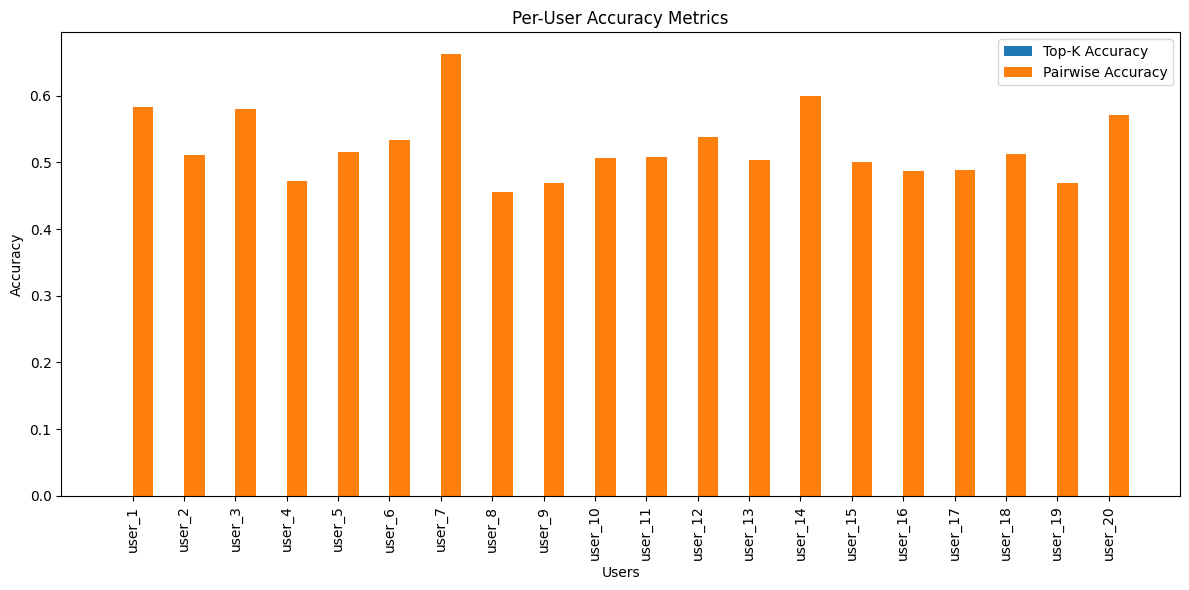

Average Top-K Accuracy: 0.0000
Average Pairwise Accuracy: 0.5234


In [5]:
movies = [node for node, data in user_movie_graph.nodes(data=True) if data.get("bipartite") == 1]
print(len(movies))
avg_top_k_accuracy, avg_pair_accuracy,results = evaluate_recommender(user_movie_graph, walk_length=3, penalty_type="b", k=len(movies)//10)

print(f"Average Top-K Accuracy: {avg_top_k_accuracy:.4f}")
print(f"Average Pairwise Accuracy: {avg_pair_accuracy:.4f}")
visualize_results(avg_top_k_accuracy, avg_pair_accuracy, results)